In [1]:
import pandas as pd
import stellargraph as sg
import scipy.sparse as sp
import numpy as np
import time
import tensorflow.keras.backend as K
import pickle
import json

In [2]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from scipy import stats

from tensorflow.keras import layers, optimizers, losses, metrics, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

### 数据预处理

In [3]:
# 去除因子为缺失值的股票
def create_mat(adj, df_path):
    adjMatDf = adj
    
    df = pd.read_csv(df_path,index_col = 0)
    df = df.dropna(how='any')
    stockCodeAr = df['stock'].values
    
    commenStockIdLi = list(set(adjMatDf.index).intersection(set(stockCodeAr)))
    
    adjMatDf = adjMatDf.loc[commenStockIdLi, commenStockIdLi]
    adjMatDf = adjMatDf.sort_index(level = stockCodeAr).sort_index(axis = 1, level = stockCodeAr)
#     adjMatDf[adjMatDf > 0] = 1
    adjMatDf = adjMatDf.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    df = df.set_index('stock').loc[adjMatDf.index]

    return adjMatDf, df

# 行业为0~30，读取为ori_df，为创建行业的邻接矩阵做准备
ori_df = pd.read_excel('monthly_indus.xlsx', index_col=0, header=None)
stock_code_list = list(ori_df.index)

# 字典存stock_code对应的行数
stock_code_id_dict = {}
for i,j in zip([i for i in range(3945)], stock_code_list):
    stock_code_id_dict[j] = i


# # 每个时间点股票的列表的列表，为求这段时间内共同的不含缺失值的股票做准备
# stock_code_list_list = []
# for month_id in range(250, 260):
#     stock_code_list_list.append(list(pd.read_csv('csv_demo_con/' + 
#                                                  str(month_id + 1) + '.csv',index_col = 0).dropna(how='any')['stock'].values))
# # 求这个时间段里都存在的股票
# common_stock_code_list = stock_code_list_list[0]
# for i in range(260-250):
#     common_stock_code_list = [x for x in common_stock_code_list if x in stock_code_list_list[i]]

if not os.path.exists('data'):
    os.makedirs('data')

'''
G是stellargraph中封装好的对象，存储图相关的信息
nodes_subjects是节点的标签，这里是norm_return
nodes_features是节点的特征，这里是因子信息
提前做好列表，方便存每个月的数据
'''
G_list = []
nodes_subjects_list = []
nodes_features_list = []

# range调整需要计算的月份，但是延迟一个月，219实际计算的是220.csv，264实际计算的是265.csv
# 文件中有220.csv到264.csv，所以range取(219, 264)即可全部读取
for month_id in range(219, 264):
    
    # if如果不存这些文件，就说明是第一次运行，则要计算邻接矩阵adj和因子矩阵factor
    # else如果已经存在，那么直接读取即可
    if not (os.path.exists("data/factor-" + str(month_id + 1) + ".csv") and os.path.exists("data/adj-" + str(month_id + 1) + ".npz")):        
        sub_ori_df = ori_df.iloc[:,month_id]

        # 这三个数组为构建稀疏矩阵做准备
        adj_row = []
        adj_col = []
        adj_data = []

        # 行业编号有30个：0~30
        for indus_code in range(31):
            sub_ori_df_of_indus_code = sub_ori_df[sub_ori_df == indus_code]
            index_of_sub_ori_df_of_indus_code = sub_ori_df_of_indus_code.index
            size = len(sub_ori_df_of_indus_code)
            if size > 1:
                for i in range(size):
                    for j in range(i, size):
                    # 若为range(i + 1, size)，则邻接矩阵的对角线为0
                        stock_1_code = index_of_sub_ori_df_of_indus_code[i]
                        stock_2_code = index_of_sub_ori_df_of_indus_code[j]
                        stock_1_id = stock_code_id_dict[stock_1_code]
                        stock_2_id = stock_code_id_dict[stock_2_code]
                        adj_row.append(stock_1_id)
                        adj_col.append(stock_2_id)
                        adj_data.append(1)

        # 直接创建稀疏的adj可以大幅加速，但还要转回dataframe，因为要根据stock_code和因子求交集
        adj_sparse = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(3945, 3945))
        adj_df = pd.DataFrame((adj_sparse).toarray(), index=stock_code_list, columns=stock_code_list)

        # 新得到adj_df, factor_df，里面包含的股票一致
        adj_df, factor_df = create_mat(adj_df, 'csv_demo_con/' + str(month_id + 1) + '.csv')
        
        # 将adj_df转回adj_sparse，创建edges为创建G对象做准备
        adj_sparse = sp.coo_matrix(adj_df.values)
        
        # 将邻接矩阵和因子矩阵保存，以后就不用再计算一遍了
        sp.save_npz('data/adj-' + str(month_id + 1) + '.npz', adj_sparse)
        factor_df.to_csv('data/factor-' + str(month_id + 1) + '.csv')
        
    else:
        adj_sparse = sp.load_npz('data/adj-' + str(month_id + 1) + '.npz')
        factor_df = pd.read_csv('data/factor-' + str(month_id + 1) + '.csv', index_col=0)    
    
    '''
        
        如
            row = [1, 3, 4, 6, 8]
            col = [3, 5, 7, 8, 10]
        则1节点和3节点有连结，3节点和5节点有连接，以此类推
        边权由weight对应的列表表示
        注意：每个节点是对应不同的股票的
    '''
    
    row = adj_sparse.row
    col = adj_sparse.col
    edges = pd.DataFrame({
        "source": row,
        "target": col,
        "weight": [1 for i in range(len(row))]
    })
    
    
    '''
        nodes是一个列表，第0个特征对应第0个节点，第1个特征对应第1个节点，以此类推
    '''
    nodes = factor_df.reset_index().loc[:,'return_1m':'return_12m']
    nodes_features_list.append(nodes)
    
    
#     # 大家共同使用第一个月的邻接矩阵
#     if month_id == 250:
#         common_edges = edges
        
    # 创建包含图信息的对象G
    G = sg.StellarGraph(nodes, edges)
    G_list.append(G)
    
    # 创建每个节点对应的标签，这里是norm_return
    node_subjects = factor_df.reset_index()['norm_return']
    nodes_subjects_list.append(node_subjects)
        
    print(month_id + 1, "has finished")

220 has finished
221 has finished
222 has finished
223 has finished
224 has finished
225 has finished
226 has finished
227 has finished
228 has finished
229 has finished
230 has finished
231 has finished
232 has finished
233 has finished
234 has finished
235 has finished
236 has finished
237 has finished
238 has finished
239 has finished
240 has finished
241 has finished
242 has finished
243 has finished
244 has finished
245 has finished
246 has finished
247 has finished
248 has finished
249 has finished
250 has finished
251 has finished
252 has finished
253 has finished
254 has finished
255 has finished
256 has finished
257 has finished
258 has finished
259 has finished
260 has finished
261 has finished
262 has finished
263 has finished
264 has finished


In [8]:
_ = adj_sparse.toarray()

In [13]:
np.sum(_)

326828

### 半监督学习

In [248]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.8, test_size=None
)
train_targets = train_subjects.values
test_targets = test_subjects.values

batch_size = 50
num_samples = [10, 5]

generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[88, 88], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1)(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.mean_squared_error,
    metrics=["mse"]
)

test_gen = generator.flow(test_subjects.index, test_targets)

history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=True
)

Epoch 1/20
53/53 - 1s - loss: 0.9988 - mse: 0.9988 - val_loss: 1.0055 - val_mse: 1.0055
Epoch 2/20
53/53 - 1s - loss: 0.9780 - mse: 0.9780 - val_loss: 0.9753 - val_mse: 0.9753
Epoch 3/20
53/53 - 1s - loss: 0.9746 - mse: 0.9746 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 4/20
53/53 - 1s - loss: 0.9744 - mse: 0.9744 - val_loss: 0.9698 - val_mse: 0.9698
Epoch 5/20
53/53 - 1s - loss: 0.9631 - mse: 0.9631 - val_loss: 0.9615 - val_mse: 0.9615
Epoch 6/20
53/53 - 1s - loss: 0.9620 - mse: 0.9620 - val_loss: 0.9537 - val_mse: 0.9537
Epoch 7/20
53/53 - 1s - loss: 0.9614 - mse: 0.9614 - val_loss: 0.9557 - val_mse: 0.9557
Epoch 8/20
53/53 - 1s - loss: 0.9591 - mse: 0.9591 - val_loss: 0.9519 - val_mse: 0.9519
Epoch 9/20
53/53 - 1s - loss: 0.9594 - mse: 0.9594 - val_loss: 0.9535 - val_mse: 0.9535
Epoch 10/20
53/53 - 1s - loss: 0.9675 - mse: 0.9675 - val_loss: 0.9707 - val_mse: 0.9707
Epoch 11/20
53/53 - 1s - loss: 0.9617 - mse: 0.9617 - val_loss: 0.9496 - val_mse: 0.9496
Epoch 12/20
53/53 - 1s - loss:

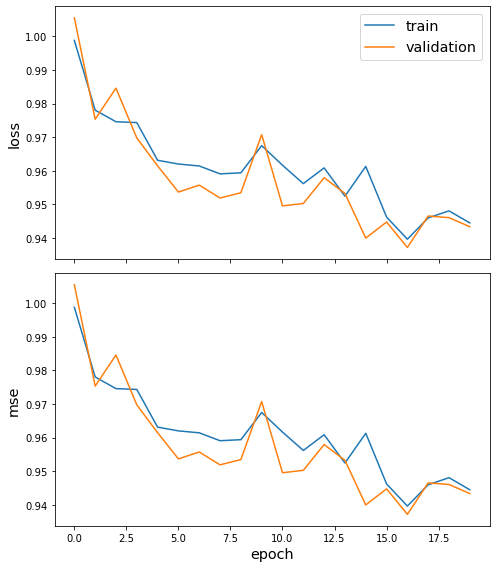

In [264]:
sg.utils.plot_history(history)

### 监督学习（前9个月预测第10个月）

In [438]:
train_list= G_list[:-1]
train_gen_list = []
n_epochs = 50

batch_size = 50
num_samples = [10]
generator = GraphSAGENodeGenerator(G_list[0], batch_size, num_samples)
# train_gen = generator.flow(list(nodes_subjects_list[0].index), nodes_subjects_list[0].values, shuffle=True)

graphsage_model = GraphSAGE(
    layer_sizes=[6], generator=generator, bias=True, dropout=0.5,
)

x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1)(x_out)

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.mean_squared_error,
    metrics=["mse"],
)

# test_gen = generator.flow(list(nodes_subjects_list[-1].index), nodes_subjects_list[-1].values, shuffle=True)

for i in range(len(train_list)):
    
    idx = i
    nodes_subjects = nodes_subjects_list[idx]
    G = G_list[idx]
    batch_size = 50
    num_samples = [10]
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(list(nodes_subjects.index), nodes_subjects.values, shuffle=True)
    train_gen_list.append(train_gen)

for i in range(n_epochs):
    idx = i % len(train_list)
    train_gen = train_gen_list[idx]
    
    model.fit(
        train_gen, epochs=1, verbose=2, shuffle=False
    )
    
    generator = GraphSAGENodeGenerator(G_list[-1], batch_size, num_samples)
    test_gen = generator.flow(list(nodes_subjects_list[-1].index), nodes_subjects_list[-1].values)
    test_predictions = model.predict(test_gen)
    test_metrics = model.evaluate(test_gen)

66/66 - 0s - loss: 1.0413 - mse: 1.0413
66/66 [==============================] - 0s 4ms/step - loss: 1.0248 - mse: 1.0248
66/66 - 0s - loss: 0.9604 - mse: 0.9604
66/66 [==============================] - 0s 4ms/step - loss: 1.0158 - mse: 1.0158
66/66 - 0s - loss: 0.9800 - mse: 0.9800
66/66 [==============================] - 0s 4ms/step - loss: 0.9886 - mse: 0.9886
66/66 - 0s - loss: 0.9545 - mse: 0.9545
66/66 [==============================] - 0s 4ms/step - loss: 1.0044 - mse: 1.0044
66/66 - 0s - loss: 0.9623 - mse: 0.9623
66/66 [==============================] - 0s 4ms/step - loss: 1.0036 - mse: 1.0036
66/66 - 0s - loss: 0.9969 - mse: 0.9969
66/66 [==============================] - 0s 4ms/step - loss: 0.9863 - mse: 0.9863
66/66 - 0s - loss: 0.9526 - mse: 0.9526
66/66 [==============================] - 0s 4ms/step - loss: 0.9921 - mse: 0.9921
66/66 - 0s - loss: 0.9583 - mse: 0.9583
66/66 [==============================] - 0s 4ms/step - loss: 1.0036 - mse: 1.0036
66/66 - 0s - loss: 0.959

KeyboardInterrupt: 

### 监督学习（一个月预测下一个月）

In [5]:
# 定义model.compile()时的metrics
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [8]:
# 提前定义一些列表方便记录数据，大循环的列表存小循环的列表
graph_history_list_list = []
model_list_list = []
train_gen_list_list = []
time_list_list = []
model_weight_list_list = []


# 选择运行run_num次
run_num = 1
# 选择进行训练的月份,end_month_id最多取
start_month_id = 220
end_month_id = 225

# 大循环记录训练了几次，计算多次是为了减少variance
# 小循环记录训练的月份
for j in range(run_num):
    num_samples = [20]
    
    # 提前定义一些列表记录小循环的数据
    graph_history_list = []
    model_list = []
    train_gen_list = []
    time_list = []
    model_weight_list = []

    # i为0代表220
    for i in range(start_month_id - 220, end_month_id - 220):

        start = time.time()
        
        # 前一个月训练，后一个月验证
        train_idx = i
        test_idx = i + 1
        

        # 用train_idx的数据生成训练集的generator
        generator = GraphSAGENodeGenerator(G=G_list[train_idx], batch_size=len(nodes_subjects_list[train_idx]), num_samples=num_samples)
        train_gen = generator.flow(list(nodes_subjects_list[train_idx].index), nodes_subjects_list[train_idx].values, shuffle=False)

        # 生成GraphSAGE模型
        graphsage_model = GraphSAGE(
            layer_sizes=[1], generator=generator, bias=True, aggregator=sg.layer.MeanAggregator, normalize=None
        )

        # 提取输出输出的tensor，用keras来构建模型
        x_inp, x_out = graphsage_model.in_out_tensors()
#         prediction = layers.Dense(units=1)(x_out)

        # 用test_idx的数据生成验证集的generator
        generator = GraphSAGENodeGenerator(G=G_list[test_idx], batch_size=len(nodes_subjects_list[test_idx]), num_samples=num_samples)
        test_gen = generator.flow(list(nodes_subjects_list[test_idx].index), nodes_subjects_list[test_idx].values)


        # 通过输入输出的tensor构建model
        model = Model(inputs=x_inp, outputs=x_out)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                                patience=10, verbose=1, mode='auto',
                                restore_best_weights=True)
        model.compile(
            optimizer=optimizers.Adam(lr=0.05),
            loss=losses.mean_squared_error,
            metrics=[pearson_r]
        )

        history = model.fit(
            train_gen, epochs=500, validation_data=test_gen, verbose=0, shuffle=False, callbacks=[monitor]
        )

        end = time.time()

        # 保存一些结果
        graph_history_list.append(history) # 保存训练过程
        model_list.append(model) # 保存model
        train_gen_list.append(train_gen) # 保存train_gen方便之后算中间层的结果
        time_list.append(end - start) # 保存运行时间
        model_weight_list.append(model.weights) # 保存model的参数
        
        print(str(i + 220) + "'s " + str(j + 1) + " run has finised")
    
    # 将小循环的数据保存
    graph_history_list_list.append(graph_history_list)
    model_list_list.append(model_list)
    train_gen_list_list.append(train_gen_list)
    time_list_list.append(time_list)
    model_weight_list_list.append(model_weight_list)

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
220's 1 run has finised


KeyboardInterrupt: 

In [998]:
# 计算图聚合后的因子，和原始的每个因子的spearman系数
for k in range(run_num):
    graph_history_list = graph_history_list_list[k]
    model_list = model_list_list[k]
    train_gen_list = train_gen_list_list[k]
    time_list = time_list_list[k]
    model_weight_list = model_weight_list_list[k]
    for i in range(start_month_id - 220, end_month_id - 220):
        # 计算reshape层的输出，如果normalization取None的话，那么reshape层输出就和lambda一样
        model = model_list[i]
        graph_layer_model = Model(inputs=model.input,
                                             outputs=model.layers[-2].output)
        graph_output = graph_layer_model.predict(train_gen_list[i])
        print(str(220 + i) + '->' + str(220 + i + 1))

        for col in graph_output_df.columns:        
            print(col, stats.spearmanr(graph_output, nodes_features_list[i][col])[0])
        print()

220->221
return_1m 0.14812962535004448
return_3m 0.944041339916606
return_6m 0.5904316929579144
return_12m 0.10743679457613449

221->222
return_1m 0.1773311382670712
return_3m 0.7201860301331485
return_6m 0.3025598618882926
return_12m -0.4057706813345885

222->223
return_1m 0.7484101305245356
return_3m 0.34072229954900995
return_6m 0.2815781081662073
return_12m 0.647427596199856

223->224
return_1m 0.532232608051731
return_3m 0.4214123341708224
return_6m 0.8220193922082993
return_12m 0.7386329928094751

224->225
return_1m 0.288165203815679
return_3m -0.5675410685233806
return_6m -0.33767327818120374
return_12m -0.20156905991253896



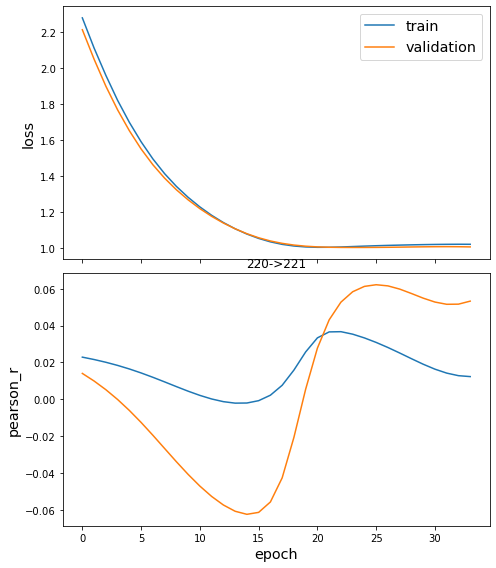

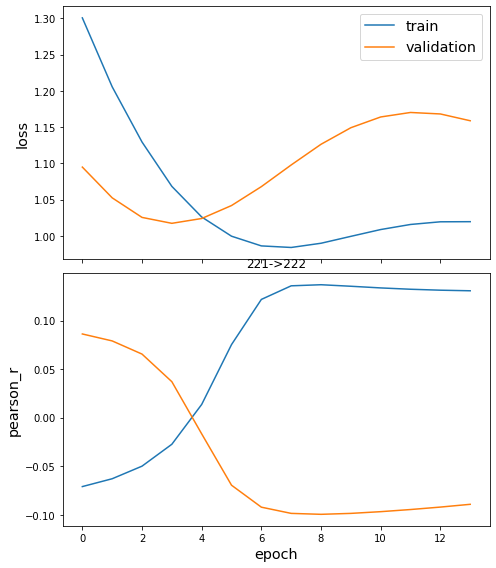

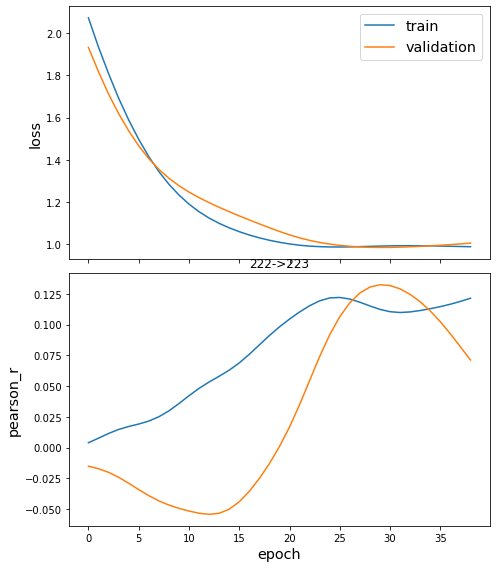

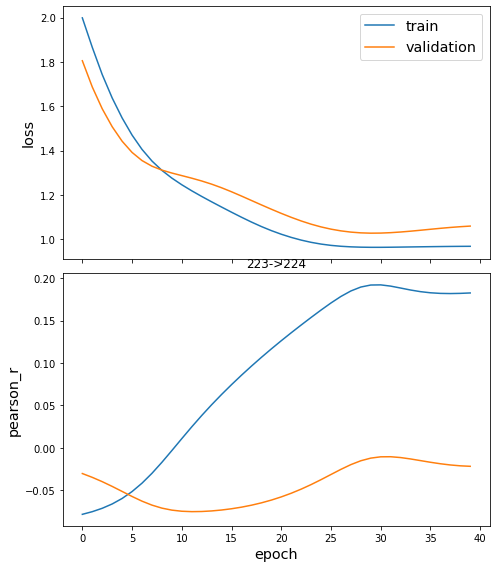

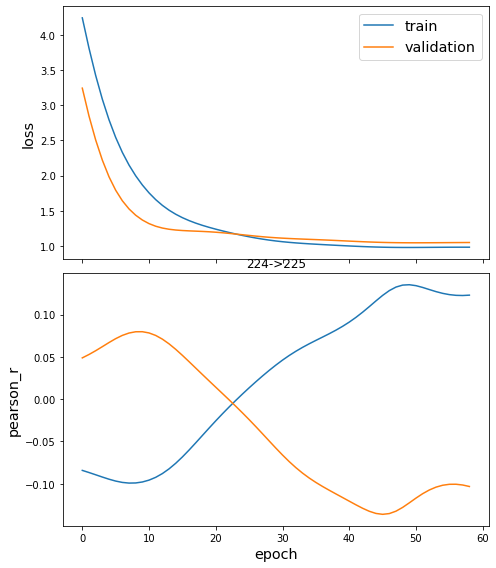

In [1002]:
# 绘制训练时loss和spearnman系数的变化过程
for k in range(run_num):
    graph_history_list = graph_history_list_list[k]
    model_list = model_list_list[k]
    train_gen_list = train_gen_list_list[k]
    time_list = time_list_list[k]
    model_weight_list = model_weight_list_list[k]
    for i in range(start_month_id - 220, end_month_id - 220):
        # 计算reshape层的输出，如果normalization取None的话，那么reshape层输出就和lambda一样
        sg.utils.plot_history(graph_history_list[i])
        plt.title(str(220 + i) + '->' + str(220 + i + 1))
        print()

In [960]:
# 参数
for k in range(run_num):
    graph_history_list = graph_history_list_list[k]
    model_list = model_list_list[k]
    train_gen_list = train_gen_list_list[k]
    time_list = time_list_list[k]
    model_weight_list = model_weight_list_list[k]
    for i in range(start_month_id - 220, end_month_id - 220):
        # 计算reshape层的输出，如果normalization取None的话，那么reshape层输出就和lambda一样
        model = model_list[i]
        print(model.weights)
        print()

[<tf.Variable 'mean_aggregator_258/bias:0' shape=(1,) dtype=float32, numpy=array([0.00897657], dtype=float32)>, <tf.Variable 'mean_aggregator_258/weight_g0:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.10019897],
       [-0.05819531],
       [ 0.02976358],
       [-0.0258929 ]], dtype=float32)>, <tf.Variable 'mean_aggregator_258/weight_g1:0' shape=(4, 0) dtype=float32, numpy=array([], shape=(4, 0), dtype=float32)>]

[<tf.Variable 'mean_aggregator_259/bias:0' shape=(1,) dtype=float32, numpy=array([0.00612045], dtype=float32)>, <tf.Variable 'mean_aggregator_259/weight_g0:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.08128747],
       [-0.0290863 ],
       [ 0.04135278],
       [-0.0330598 ]], dtype=float32)>, <tf.Variable 'mean_aggregator_259/weight_g1:0' shape=(4, 0) dtype=float32, numpy=array([], shape=(4, 0), dtype=float32)>]

[<tf.Variable 'mean_aggregator_260/bias:0' shape=(1,) dtype=float32, numpy=array([0.01861954], dtype=float32)>, <tf.Variable 'mean_aggregator_260/weight_g

In [917]:
model.summary()

Model: "model_359"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_448 (InputLayer)          [(None, 20, 4)]      0                                            
__________________________________________________________________________________________________
input_447 (InputLayer)          [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
reshape_478 (Reshape)           (None, 1, 20, 4)     0           input_448[0][0]                  
__________________________________________________________________________________________________
dropout_543 (Dropout)           (None, 1, 4)         0           input_447[0][0]                  
__________________________________________________________________________________________

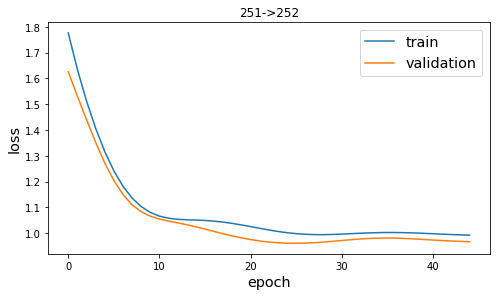

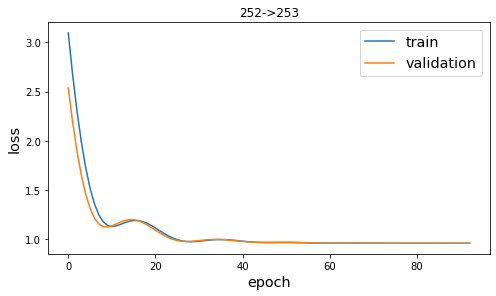

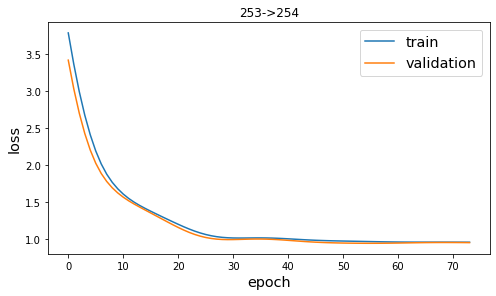

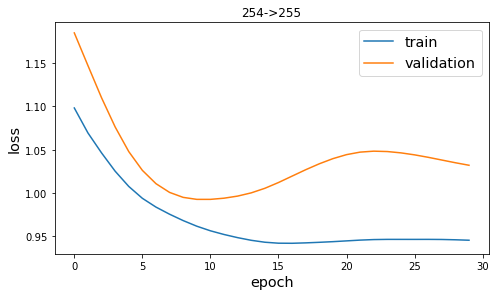

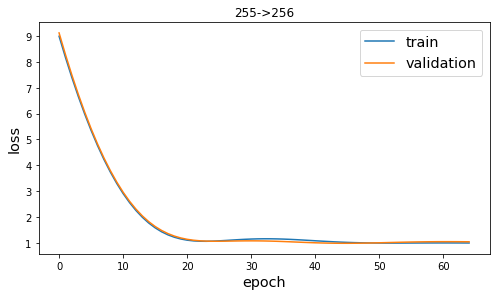

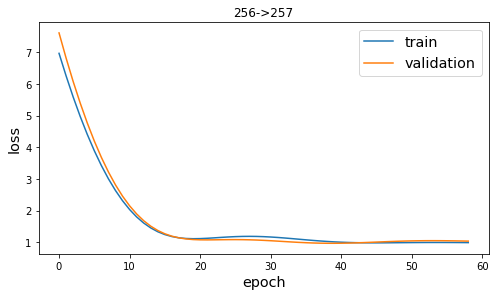

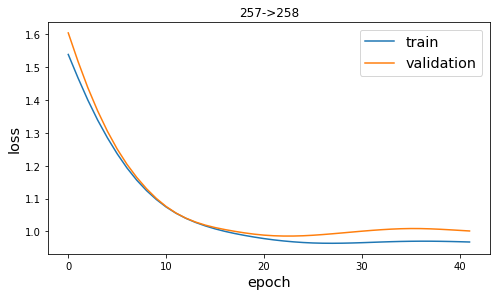

In [908]:
# train和val的loss的曲线
for i in range(7):
    sg.utils.plot_history(graph_history_list[i])
    plt.title(str(251 + i) + '->' + str(251 + i + 1))

In [909]:
# 最小的val_loss
for i in range(7):
    print("训练月份:" + str(251 + i), "  最小val_loss:"+str(min(graph_history_list[i].history['val_loss'])))

训练月份:251   最小val_loss:0.9612695574760437
训练月份:252   最小val_loss:0.9589792490005493
训练月份:253   最小val_loss:0.9448094964027405
训练月份:254   最小val_loss:0.9927217960357666
训练月份:255   最小val_loss:0.9847615957260132
训练月份:256   最小val_loss:0.9690956473350525
训练月份:257   最小val_loss:0.9857341647148132


In [915]:
for i in range(7):
    # 计算reshape层的输出，如果normalization取None的话，那么reshape层输出就和lambda一样
    model = model_list[i]
    graph_layer_model = Model(inputs=model.input,
                                         outputs=model.layers[-2].output)
    graph_output = graph_layer_model.predict(train_gen_list[i])
    print(str(251 + i) + '->' + str(251 + i + 1))
    
    for col in graph_output_df.columns:        
        print(col, stats.spearmanr(graph_output, nodes_features_list[i][col])[0])
    print()

251->252
return_1m 0.7805253111817136
return_3m 0.19679328167782667
return_6m -0.15918040736196476
return_12m -0.6580393203344702

252->253
return_1m 0.8622957496446948
return_3m 0.6160145809970681
return_6m 0.3088850794903378
return_12m -0.08021610982887209

253->254
return_1m 0.7628715007691188
return_3m 0.7518793891983431
return_6m 0.30430389174726946
return_12m 0.008872625694018007

254->255
return_1m 0.7892274791347624
return_3m 0.45280286202788
return_6m 0.6857399182606347
return_12m 0.4028187497551457

255->256
return_1m -0.3448602656833912
return_3m -0.6786592389630038
return_6m -0.9282541837060089
return_12m -0.8452378830348647

256->257
return_1m 0.8017800204209233
return_3m 0.07755489828914315
return_6m 0.043454902205841396
return_12m 0.3202445638043646

257->258
return_1m 0.26846731369133486
return_3m 0.5390900236140626
return_6m 0.971286510345575
return_12m 0.6631475398976573



In [871]:
model.summary()

Model: "model_292"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_412 (InputLayer)          [(None, 20, 4)]      0                                            
__________________________________________________________________________________________________
input_411 (InputLayer)          [(None, 1, 4)]       0                                            
__________________________________________________________________________________________________
reshape_442 (Reshape)           (None, 1, 20, 4)     0           input_412[0][0]                  
__________________________________________________________________________________________________
dropout_507 (Dropout)           (None, 1, 4)         0           input_411[0][0]                  
__________________________________________________________________________________________

In [857]:
# 计算reshape层的输出
graph_layer_model = Model(inputs=model.input,
                                     outputs=model.layers[-2].output)
graph_output = graph_layer_model.predict(train_gen)
graph_output
# graph_output_df = pd.DataFrame(graph_output, columns=nodes_features_list[0].columns, index=nodes_features_list[0].index)
# graph_output_df

array([[-0.0467811 ],
       [ 0.10553895],
       [ 0.10810331],
       ...,
       [ 0.0232849 ],
       [-0.04370311],
       [ 0.1822749 ]], dtype=float32)

In [854]:
# 计算lambda层的输出，如果GraphSage的Normalization为None，则lambda层的输出和reshape一样，维度稍有不同
graph_layer_model = Model(inputs=model.input,
                                     outputs=model.layers[-3].output)
graph_output = graph_layer_model.predict(train_gen)
graph_output
# graph_output_df = pd.DataFrame(graph_output, columns=nodes_features_list[0].columns, index=nodes_features_list[0].index)
# graph_output_df

array([[[-0.0467811 ]],

       [[ 0.10553895]],

       [[ 0.10810331]],

       ...,

       [[ 0.0232849 ]],

       [[-0.04370311]],

       [[ 0.1822749 ]]], dtype=float32)

In [849]:
#
nodes_features_list[train_idx]

,return_1m,return_3m,return_6m,return_12m
0,-0.651194,-0.507459,-0.605506,-0.775750
1,0.802406,1.425020,0.928351,0.630577
2,0.831647,0.447585,-0.019528,-0.139321
3,0.595956,0.536786,0.339709,0.179878
4,0.757639,-0.174567,1.537890,1.654370
...,...,...,...,...
3280,-0.270204,0.135758,-0.271881,0.952136
3281,1.787710,0.632194,-0.912593,0.047593
3282,0.851063,-0.608392,0.340049,0.710388
3283,-0.865753,0.663515,-0.082566,-0.172486


In [860]:
for col in graph_output_df.columns:
    print(col, stats.spearmanr(graph_output, nodes_features_list[idx][col])[0])

return_1m 0.8870090551310105
return_3m 0.6164263436844841
return_6m 0.2875541061237788
return_12m 0.032396489702978606


In [829]:
for col in graph_output_df.columns:
    print(col, stats.spearmanr(graph_output_df[col], nodes_features_list[idx][col])[0])

return_1m 0.8183520640205287
return_3m -0.419083245552486
return_6m -0.017989884473922416
return_12m 0.024040264860314027


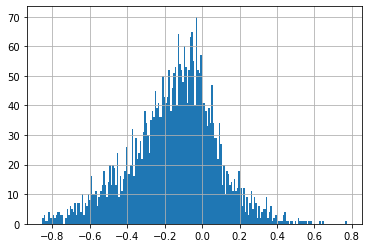

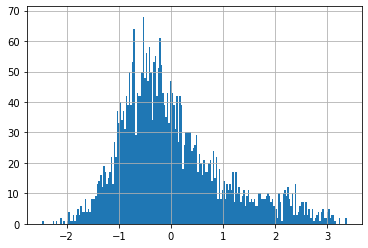

In [571]:
graph_output_df['DP'].hist(bins = 200)
plt.show()
nodes_features_list[0]['DP'].hist(bins=200)
plt.show()

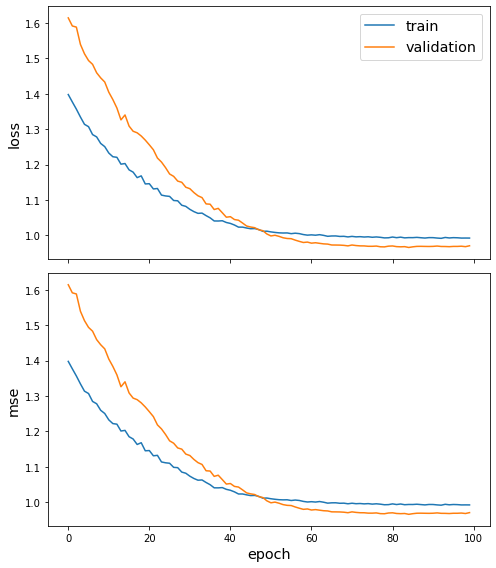

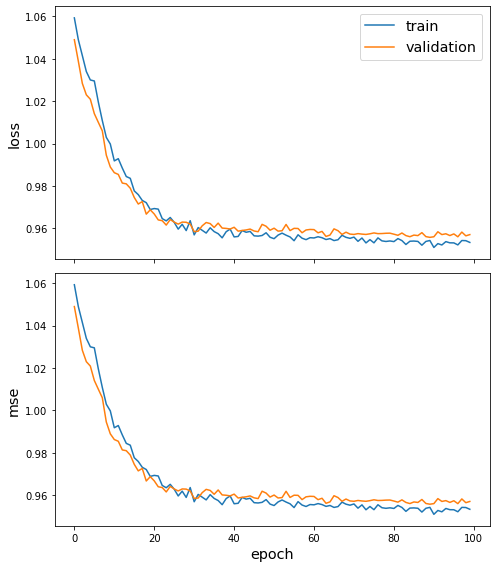

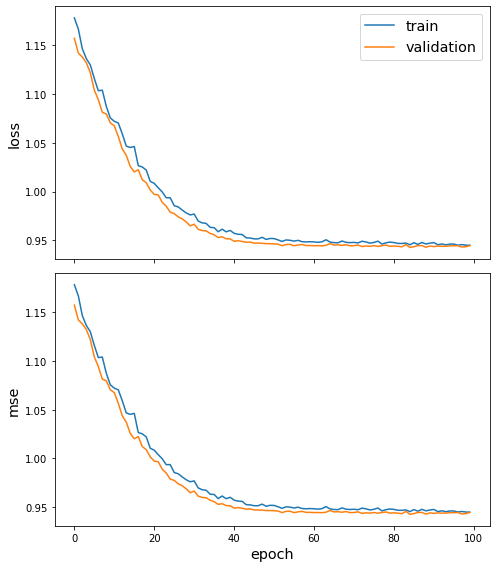

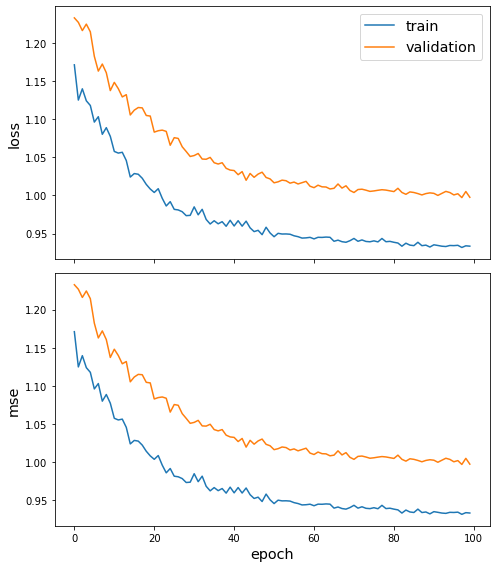

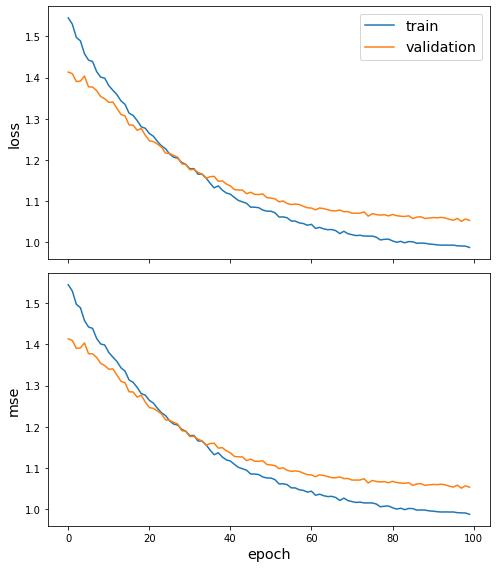

In [720]:
for i in range(5):
    sg.utils.plot_history(graph_history_list[i])

### 拼接向量模型

In [614]:
# graphsage_model = GraphSAGE(
#         layer_sizes=[7], generator=generator, bias=True, aggregator=sg.layer.MeanAggregator
#     )
# x_inp, x_out = graphsage_model.in_out_tensors()
# prediction = layers.Dense(units=1)(x_out)
# model = Model(inputs=x_inp, outputs=prediction)
# input_ = model.input

# agg_output = model.layers[-4].output
# concat_output = layers.concatenate([agg_output, model.input[0]])

# graphsage_model = GraphSAGE(
#         layer_sizes=[14], generator=generator, bias=True, aggregator=sg.layer.MeanAggregator
#     )
# x_inp, x_out = graphsage_model.in_out_tensors()
# prediction = layers.Dense(units=1)(x_out)
# model = Model(inputs=x_inp, outputs=prediction)

# reshape_output = model.layers[-3](concat_output)
# lambda_output = model.layers[-2](reshape_output)
# final_output = layers.Dense(units=1)(lambda_output)

# model1 = Model(inputs=input_, outputs=final_output)
# model1.summary()

In [669]:
n_epochs = 50

batch_size = len(nodes_subjects.index)
num_samples = [20]
graph_history_list = []


for i in range(3,4):
    # 可取1到7
    idx = i
    test_idx = i + 1

    nodes_subjects = nodes_subjects_list[idx]
    G = G_list[idx]

    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    # train_gen = generator.flow(list(nodes_subjects_list[0].index), nodes_subjects_list[0].values, shuffle=True)
    train_gen = generator.flow(list(nodes_subjects.index), nodes_subjects.values, shuffle=False)

    graphsage_model = GraphSAGE(
        layer_sizes=[7], generator=generator, bias=True, aggregator=sg.layer.MeanAggregator
    )
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=1)(x_out)
    model = Model(inputs=x_inp, outputs=prediction)
    input_ = model.input

    generator = GraphSAGENodeGenerator(G_list[test_idx], batch_size, num_samples)
    test_gen = generator.flow(list(nodes_subjects_list[test_idx].index), nodes_subjects_list[test_idx].values)
    # test_predictions = model.predict(test_gen)
    # test_metrics = model.evaluate(test_gen)

    agg_output = model.layers[-4].output
    concat_output = layers.concatenate([agg_output, model.input[0]])

    graphsage_model = GraphSAGE(
            layer_sizes=[14], generator=generator, bias=True, aggregator=sg.layer.MeanAggregator
        )
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=1)(x_out)
    model = Model(inputs=x_inp, outputs=prediction)

    reshape_output = model.layers[-3](concat_output)
    lambda_output = model.layers[-2](reshape_output)
    final_output = layers.Dense(units=1)(lambda_output)

    model = Model(inputs=input_, outputs=final_output)
    
    
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.mean_squared_error,
        metrics=["mse"],
    )

    history = model.fit(
        train_gen, epochs=100, validation_data=test_gen, verbose=2, shuffle=False #, callbacks=[monitor]
    )

    graph_history_list.append(history)

Epoch 1/100
1/1 - 0s - loss: 1.0303 - mse: 1.0303 - val_loss: 1.0394 - val_mse: 1.0394
Epoch 2/100
1/1 - 0s - loss: 1.0218 - mse: 1.0218 - val_loss: 1.0372 - val_mse: 1.0372
Epoch 3/100
1/1 - 0s - loss: 1.0177 - mse: 1.0177 - val_loss: 1.0289 - val_mse: 1.0289
Epoch 4/100
1/1 - 0s - loss: 1.0172 - mse: 1.0172 - val_loss: 1.0230 - val_mse: 1.0230
Epoch 5/100
1/1 - 0s - loss: 1.0134 - mse: 1.0134 - val_loss: 1.0239 - val_mse: 1.0239
Epoch 6/100
1/1 - 0s - loss: 1.0107 - mse: 1.0107 - val_loss: 1.0188 - val_mse: 1.0188
Epoch 7/100
1/1 - 0s - loss: 1.0053 - mse: 1.0053 - val_loss: 1.0156 - val_mse: 1.0156
Epoch 8/100
1/1 - 0s - loss: 1.0063 - mse: 1.0063 - val_loss: 1.0131 - val_mse: 1.0131
Epoch 9/100
1/1 - 0s - loss: 1.0023 - mse: 1.0023 - val_loss: 1.0134 - val_mse: 1.0134
Epoch 10/100
1/1 - 0s - loss: 0.9949 - mse: 0.9949 - val_loss: 1.0090 - val_mse: 1.0090
Epoch 11/100
1/1 - 0s - loss: 0.9950 - mse: 0.9950 - val_loss: 1.0048 - val_mse: 1.0048
Epoch 12/100
1/1 - 0s - loss: 0.9929 - ms

Epoch 95/100
1/1 - 0s - loss: 0.9668 - mse: 0.9668 - val_loss: 0.9806 - val_mse: 0.9806
Epoch 96/100
1/1 - 0s - loss: 0.9668 - mse: 0.9668 - val_loss: 0.9800 - val_mse: 0.9800
Epoch 97/100
1/1 - 0s - loss: 0.9667 - mse: 0.9667 - val_loss: 0.9801 - val_mse: 0.9801
Epoch 98/100
1/1 - 0s - loss: 0.9666 - mse: 0.9666 - val_loss: 0.9801 - val_mse: 0.9801
Epoch 99/100
1/1 - 0s - loss: 0.9667 - mse: 0.9667 - val_loss: 0.9799 - val_mse: 0.9799
Epoch 100/100
1/1 - 0s - loss: 0.9669 - mse: 0.9669 - val_loss: 0.9805 - val_mse: 0.9805


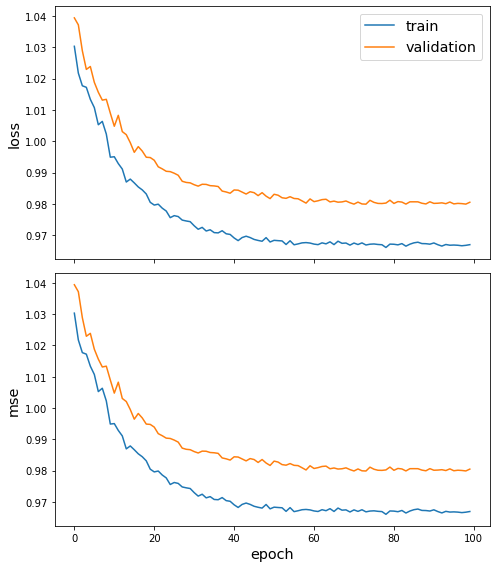

In [670]:
sg.utils.plot_history(history)

In [657]:
stats.spearmanr(np.reshape(model.predict(test_gen), (3285,1)), np.reshape(nodes_subjects_list[1].values, (3285, 1)).astype(np.float32))

SpearmanrResult(correlation=-0.03515181183835436, pvalue=0.04394877297713562)

In [618]:
model.summary()

Model: "model_162"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_298 (InputLayer)          [(None, 20, 7)]      0                                            
__________________________________________________________________________________________________
input_297 (InputLayer)          [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
reshape_328 (Reshape)           (None, 1, 20, 7)     0           input_298[0][0]                  
__________________________________________________________________________________________________
dropout_393 (Dropout)           (None, 1, 7)         0           input_297[0][0]                  
__________________________________________________________________________________________

### BaseLine

In [14]:
# 定义model.compile()时的metrics
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# nodes_features_list[0]
# nodes_subjects_list[0]
base_line_history_list = []
test_result_list = []

for i in range(263-220):
    # Build the neural network
    model = Sequential()
    model.add(Dense(1, input_dim = nodes_features_list[0].shape[1]))


    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01))
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                            patience=10, verbose=0, mode='auto', 
                            restore_best_weights=True)

    train_idx = i
    val_idx = i + 1
    test_idx = i + 2
    history = model.fit(nodes_features_list[train_idx],nodes_subjects_list[train_idx],
              validation_data=(nodes_features_list[val_idx],nodes_subjects_list[val_idx]),
              verbose=0,epochs=500,
              callbacks=[monitor])
    
    base_line_history_list.append(history)    
    test_pred = model.predict(nodes_features_list[test_idx])
    
    ic = stats.spearmanr(nodes_subjects_list[test_idx].values, test_pred.reshape(test_pred.shape[0]))
    test_result_list.append(ic[0])
    print(ic[0])
    print(str(i + 220) + " has finished\n")

0.06164730115095107
220 has finished

0.18713981783470232
221 has finished

0.02565402230543631
222 has finished

-0.05253861406567773
223 has finished

-0.04293084773820438
224 has finished

-0.04434349795396013
225 has finished

-0.10758758320543993
226 has finished

-0.039854609353877676
227 has finished

-0.11311760801271735
228 has finished

0.031364005657212105
229 has finished

0.2139206342116241
230 has finished

0.000409399746298077
231 has finished

0.1199837888511182
232 has finished

-0.011375523260752057
233 has finished

0.07233468367786886
234 has finished

-0.05670906581690788
235 has finished

0.17214901142954125
236 has finished

0.09973318409335412
237 has finished

0.09123076762010976
238 has finished

0.022582132992285703
239 has finished

0.16660527070012635
240 has finished

-0.11950483790191657
241 has finished

-0.07982062964226469
242 has finished

0.1380972419956543
243 has finished

-0.025632607957195866
244 has finished

0.19606814411245752
245 has finished

### 每个月是一个batch

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# nodes_features_list[0]
# nodes_subjects_list[0]
base_line_history_list = []
test_result_list = []

model = Sequential()
model.add(Dense(1, input_dim = nodes_features_list[0].shape[1]))


model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=10, verbose=0, mode='auto', 
                        restore_best_weights=True)

for i in range(263-220):
    # Build the neural network


    train_idx = i
    val_idx = i + 1
    test_idx = i + 2
    history = model.fit(nodes_features_list[train_idx],nodes_subjects_list[train_idx],
              validation_data=(nodes_features_list[val_idx],nodes_subjects_list[val_idx]),
              verbose=0,epochs=500,
              callbacks=[monitor])
    
    base_line_history_list.append(history)    
    test_pred = model.predict(nodes_features_list[test_idx])
    
    ic = stats.spearmanr(nodes_subjects_list[test_idx].values, test_pred.reshape(test_pred.shape[0]))
    test_result_list.append(ic[0])
    print(ic[0])
    print(str(i + 220) + " has finished\n")

In [35]:
np.mean(test_result_list)

0.01895368363875288

In [21]:
np.reshape(nodes_subjects_list[0].values)

array([-0.619238 ,  2.66356  , -0.0972454, ...,  0.552247 ,  0.206293 ,
       -0.430632 ])

In [24]:
test_pred.reshape(test_pred.shape[0])

array([ 0.04045954, -0.14430866, -0.00407246, ...,  0.05480596,
       -0.05131277,  0.01349778], dtype=float32)

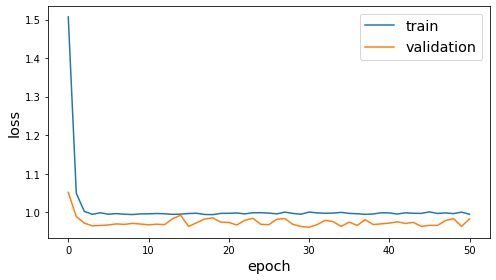

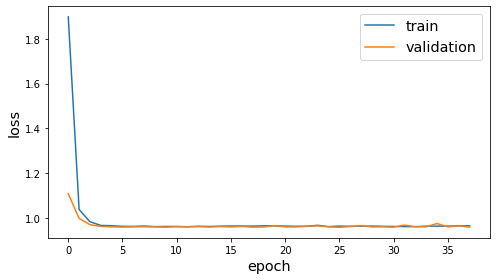

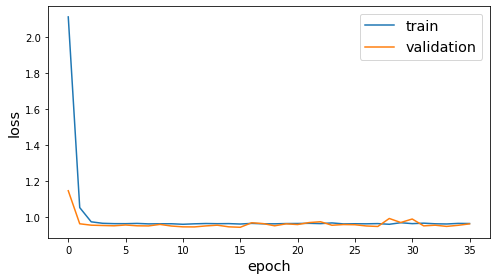

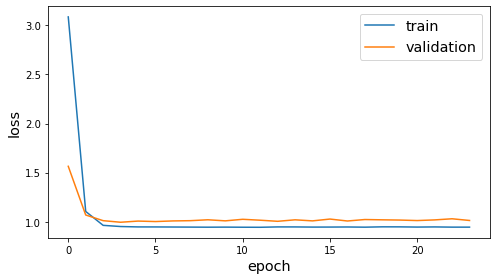

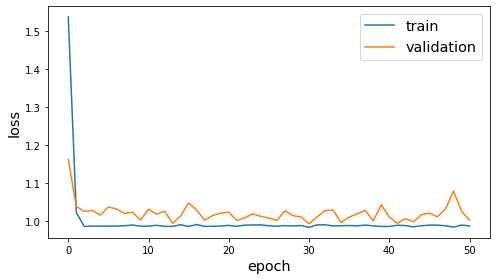

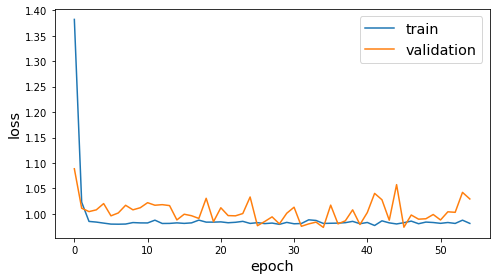

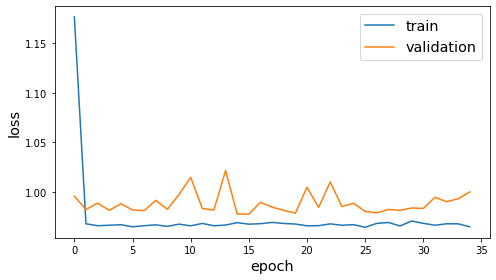

In [913]:
for i in range(7):
    sg.utils.plot_history(base_line_history_list[i])

In [914]:
for i in range(7):
    print("训练月份:" + str(251 + i), "  最小val_loss:"+str(min(base_line_history_list[i].history['val_loss'])))

训练月份:251   最小val_loss:0.9611257314682007
训练月份:252   最小val_loss:0.958763599395752
训练月份:253   最小val_loss:0.9430077075958252
训练月份:254   最小val_loss:0.9949350953102112
训练月份:255   最小val_loss:0.9923650622367859
训练月份:256   最小val_loss:0.9734570980072021
训练月份:257   最小val_loss:0.9775859117507935


### 中间层测试

In [ ]:
def create_mat(adj, df_path):
    adjMatDf = adj
    
    df = pd.read_csv(df_path,index_col = 0)
    df = df.dropna(how='any')
    stockCodeAr = df['stock'].values
    
    commenStockIdLi = list(set(adjMatDf.index).intersection(set(stockCodeAr)))
    
    adjMatDf = adjMatDf.loc[commenStockIdLi, commenStockIdLi]
    adjMatDf = adjMatDf.sort_index(level = stockCodeAr).sort_index(axis = 1, level = stockCodeAr)
#     adjMatDf[adjMatDf > 0] = 1
    adjMatDf = adjMatDf.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    df = df.set_index('stock').loc[adjMatDf.index]

    return adjMatDf, df

ori_df = pd.read_excel('monthly_indus.xlsx', index_col=0, header=None)
# 行业为0~30

stock_code_list = list(ori_df.index)

# 字典存stock_code对应的行数
stock_code_id_dict = {}
for i,j in zip([i for i in range(3945)], stock_code_list):
    stock_code_id_dict[j] = i

    
stock_code_list_list = []
for month_id in range(250, 260):
    stock_code_list_list.append(list(pd.read_csv('csv_demo_con/' + str(month_id + 1) + '.csv',index_col = 0).dropna(how='any')['stock'].values))

# 求这个时间段里都存在的股票
common_stock_code_list = stock_code_list_list[0]
for i in range(260-250):
    common_stock_code_list = [x for x in common_stock_code_list if x in stock_code_list_list[i]]

G_list = []
nodes_subjects_list = []
nodes_features_list = []

# range调整需要计算的月份，但是延迟一个月，220实际计算的是221.csv，264实际计算的是265.csv
for month_id in range(250, 260):
    sub_ori_df = ori_df.iloc[:,month_id]
    # 行业编号有30个：0~30
    adj_row = []
    adj_col = []
    adj_data = []
    for indus_code in range(31):
    # 有0~30行业编号
        sub_ori_df_of_indus_code = sub_ori_df[sub_ori_df == indus_code]
        index_of_sub_ori_df_of_indus_code = sub_ori_df_of_indus_code.index
        size = len(sub_ori_df_of_indus_code)
        if size > 1:
            for i in range(size):
                for j in range(i, size):
                # 若为range(i + 1, size)，则取消自相关
                    stock_1_code = index_of_sub_ori_df_of_indus_code[i]
                    stock_2_code = index_of_sub_ori_df_of_indus_code[j]
                    stock_1_id = stock_code_id_dict[stock_1_code]
                    stock_2_id = stock_code_id_dict[stock_2_code]
                    adj_row.append(stock_1_id)
                    adj_col.append(stock_2_id)
                    adj_data.append(1)
    
    adj_sparse = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(3945, 3945))
#     adj_df = pd.DataFrame((adj_sparse + adj_sparse.T).toarray(), index=stock_code_list, columns=stock_code_list)
    adj_df = pd.DataFrame((adj_sparse).toarray(), index=stock_code_list, columns=stock_code_list)
    
    adj_df, factor_df = create_mat(adj_df, 'csv_demo_con/' + str(month_id + 1) + '.csv')
    
    adj_df = adj_df.loc[common_stock_code_list,common_stock_code_list]
    factor_df = factor_df.loc[common_stock_code_list,:]
    
    adj_sparse = sp.coo_matrix(adj_df.values)
    row = adj_sparse.row
    col = adj_sparse.col
    edges = pd.DataFrame({
        "source": row,
        "target": col,
        "weight": [1 for i in range(len(row))]
    })
#     nodes = factor_df.reset_index().loc[:,'EP':'CON_ROE_REL']
    nodes = factor_df.reset_index().loc[:,'return_1m':'return_12m']
    nodes_features_list.append(nodes)
    
    if month_id == 250:
        common_edges = edges
    
    G = sg.StellarGraph(nodes, common_edges)
    G_list.append(G)
    
    node_subjects = factor_df.reset_index()['norm_return']
    nodes_subjects_list.append(node_subjects)
        
    print(month_id + 1, "has finished")
    
#     break